In [3]:
import pandas as pd
import numpy as np

In [4]:
# Reading dataset with skewed distributions
df = pd.read_csv('./data/Data_to_Transform.csv')

array([[<AxesSubplot:title={'center':'Moderate Positive Skew'}>,
        <AxesSubplot:title={'center':'Highly Positive Skew'}>],
       [<AxesSubplot:title={'center':'Moderate Negative Skew'}>,
        <AxesSubplot:title={'center':'Highly Negative Skew'}>]],
      dtype=object)

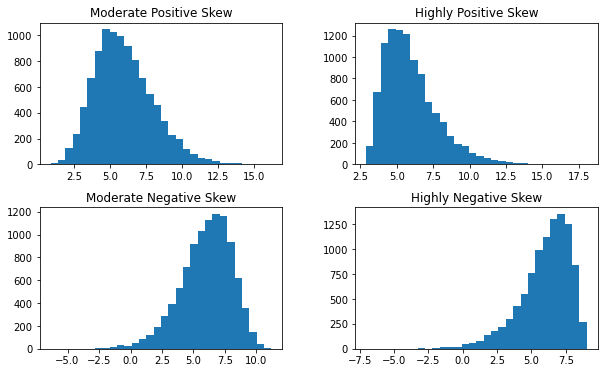

In [5]:
df.hist(grid=False, figsize=(10, 6), bins=30)

In [6]:
# df.agg(['skew', 'kurtosis']).transpose()

array([[<AxesSubplot:title={'center':'Moderate Positive Skew'}>]],
      dtype=object)

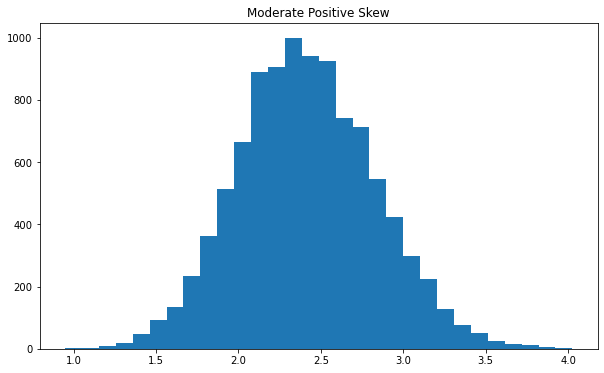

In [7]:
# df.insert(len(df.columns), 'A_Sqrt',
#          np.sqrt(df.iloc[:,0]))

# df['A_Sqrt'].hist(grid=False, figsize=(10, 6), bins=30)

pd.DataFrame(np.sqrt(df.iloc[:,0])).hist(grid=False, figsize=(10, 6), bins=30)

array([[<AxesSubplot:title={'center':'Moderate Negative Skew'}>]],
      dtype=object)

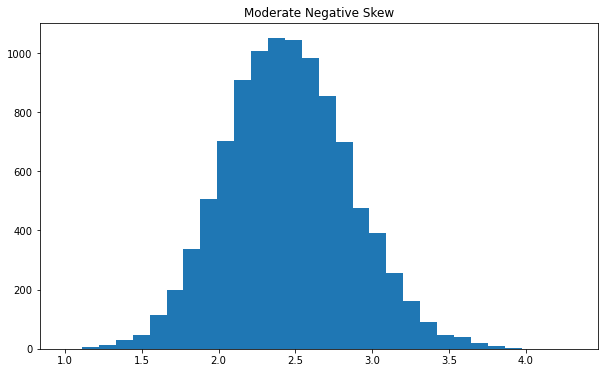

In [10]:
pd.DataFrame(np.sqrt(max(df.iloc[:, 2]+1) - df.iloc[:, 2])).hist(grid=False, figsize=(10, 6), bins=30)

array([[<AxesSubplot:title={'center':'Highly Positive Skew'}>]],
      dtype=object)

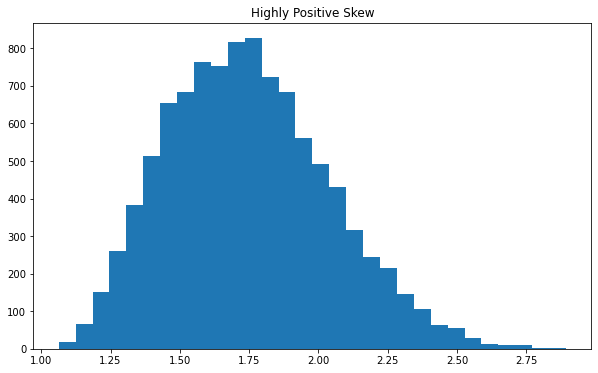

In [11]:
pd.DataFrame(np.log(df['Highly Positive Skew'])).hist(grid=False, figsize=(10, 6), bins=30)

array([[<AxesSubplot:title={'center':'Moderate Negative Skew'}>]],
      dtype=object)

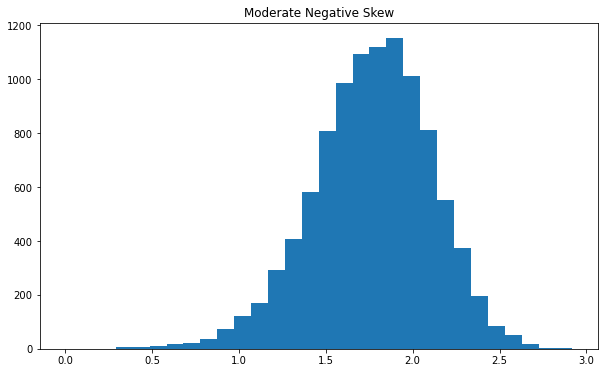

In [12]:
pd.DataFrame(np.log(max(df.iloc[:, 2] + 1) - df.iloc[:, 2])).hist(grid=False, figsize=(10, 6), bins=30)

In [15]:

import inspect
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer

scaler = MinMaxScaler()
type(scaler)
# scaler.__module__
# type('log')
isinstance(type('log'), str)
isinstance(scaler, MinMaxScaler)

True

In [16]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

ct = ColumnTransformer(
    [("norm1", scaler, ['Highly Positive Skew', 'Moderate Negative Skew'])])

df_res = ct.fit_transform(df)

ct


ColumnTransformer(transformers=[('norm1', MinMaxScaler(),
                                 ['Highly Positive Skew',
                                  'Moderate Negative Skew'])])

In [29]:
from pandas import DataFrame, concat
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import MinMaxScaler, StandardScaler
class DFColTransformer(ColumnTransformer):

    def __init__(
        self,
        transformers,
        *,
        remainder="passthrough",
        sparse_threshold=0.3,
        n_jobs=None,
        transformer_weights=None,
        verbose=False,
        verbose_feature_names_out=False,
    ):  
        super(DFColTransformer,self).__init__(
                transformers=transformers,
                remainder=remainder,
                sparse_threshold=sparse_threshold,
                n_jobs=n_jobs,
                transformer_weights=transformer_weights,
                verbose=verbose,
                verbose_feature_names_out=verbose_feature_names_out)

    def fit(self, X, y=None):
        if type(X) != DataFrame:
            raise TypeError("Only DataFrame is accepted")
        self.features = X.columns
        return super().fit(X, y=None)


    def transform(self, X):
        if type(X) != DataFrame:
            raise TypeError("Only DataFrame is accepted")

        if type(X) == DataFrame:
            return DataFrame(super().transform(X), columns=self.features)[self.features]
        else:
            return super().transform(X)

    def fit_transform(self, X, y=None):
        if type(X) != DataFrame:
            raise TypeError("Only DataFrame is accepted")

        fit_res = super().fit_transform(X, y)
        if type(X) == DataFrame:
            self.features = X.columns
            if self.remainder == "passthrough":
                return DataFrame(fit_res, columns=self.get_feature_names_out())[self.features]
            elif self.remainder == "drop":
                return DataFrame(fit_res, columns=self.get_feature_names_out())
        else:
            return fit_res


    def inverse_transform(self, Xt):

        res_inner = Xt.copy()
        df_res = DataFrame([])

        for transformer in self.transformers_[:-1]:
            trans_inner_id = transformer[0]
            trans_inner = transformer[1]
            cols_t = transformer[2]
            if type(Xt) == DataFrame:
                if hasattr(transformer[1], 'inverse_transform'):
                    if self.remainder == "drop" and self.verbose_feature_names_out == True:
                        cols_t = [ trans_inner_id+"__"+col_t for col_t in cols_t]
                    
                    res_inner.loc[:,cols_t] = trans_inner.inverse_transform(Xt[cols_t])
        
        return res_inner[self.features]


    

In [32]:
scaler1 = MinMaxScaler()
# scaler2 = StandardScaler()
ct = DFColTransformer(
    [("scale1", scaler1, ['Highly Positive Skew'])
    #  ("scale2", scaler2, ['Moderate Negative Skew'])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
    )

pipline1 = Pipeline(steps=[('DFColTransformer', ct)])
df_res = ct.fit_transform(df)

display(df)

pipline1.inverse_transform(df_res)

,Moderate Positive Skew,Highly Positive Skew,Moderate Negative Skew,Highly Negative Skew
0,0.899990,2.895074,11.180748,9.027485
1,1.113554,2.962385,10.842938,9.009762
2,1.156830,2.966378,10.817934,9.006134
3,1.264131,3.000324,10.764570,9.000125
4,1.323914,3.012109,10.753117,8.981296
...,...,...,...,...
9995,14.749050,16.289513,-2.980821,-3.254882
9996,14.854474,16.396252,-3.147526,-3.772332
9997,15.262103,17.102991,-3.517256,-4.717950
9998,15.269983,17.628467,-4.689833,-5.670496


,Moderate Positive Skew,Highly Positive Skew,Moderate Negative Skew,Highly Negative Skew
0,0.899990,2.895074,11.180748,9.027485
1,1.113554,2.962385,10.842938,9.009762
2,1.156830,2.966378,10.817934,9.006134
3,1.264131,3.000324,10.764570,9.000125
4,1.323914,3.012109,10.753117,8.981296
...,...,...,...,...
9995,14.749050,16.289513,-2.980821,-3.254882
9996,14.854474,16.396252,-3.147526,-3.772332
9997,15.262103,17.102991,-3.517256,-4.717950
9998,15.269983,17.628467,-4.689833,-5.670496


In [19]:
scaler1.inverse_transform(scaler1.fit_transform(df))

array([[ 0.89999032,  2.89507379, 11.18074757,  9.02748472],
       [ 1.1135538 ,  2.96238488, 10.84293804,  9.00976197],
       [ 1.15683006,  2.96637753, 10.81793375,  9.00613412],
       ...,
       [15.26210272, 17.10299067, -3.51725593, -4.71794956],
       [15.26998343, 17.62846709, -4.68983325, -5.67049556],
       [16.204517  , 18.05233051, -6.33567897, -7.03609125]])